# Motivation:

For my CSCI capstone project I am collaborating to develop a moible application that employes computer vision to preform object detection and ideally segmentation on ultrasound images. The objective is to help people in medically disparaged places use the powerful but difficult technology. Some of the limitations imposed on this project were the lack of readily availible electricity and modern computing hardware. Because of this our scope for model complexity is limited to reserve enery draw on phones.

Deep covolutional neural networks, like we have chosen to employ, trade sphicsticated results for large computation time and lack of interpretability. While other methods of statistical analysis or machine learning would struggle to capsture the complexity of the data and underfit they have appeal because of their preformant nature. 


## Problems I will be trying to solve

For my final project I will be preforming a exporatory analysis on a dataset of ultrasound images with two goals in mind(along with their relevant sub-goals):
1. Classify images using non-neural network approaches
	1. Classify images based on the body part being scanned
	2. Classify images as quality scans
2. Search for statistical methods to help assist neural networks classification accuracy
	1. Detect features such as scan depth, general scan quality
	2. Preforming pre-processing on scans
	3. Find correlations between general image features and scan types
	4. Detect anomalies such as a incorrectly preformed scan

# Imports and notebook setup

We will be using industry standard data analsis and machine learning tools to do our exploration. 

## Install and import libraries

In [1]:
! pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
import os
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import cv2
import urllib.request
from tqdm import tqdm
from IPython.display import display, Markdown, Latex, Image

## Dataset Construction

### Downloading Dataset

In [3]:
if not os.path.exists('./data/'):
    LARGE_DATASET_URLS = [
        'https://github.com/ButterflyNetwork/MITGrandHack2018/releases/download'
        '/v.0.0.1/butterfly_dataset_test.tar.gz',
        'https://github.com/ButterflyNetwork/MITGrandHack2018/releases/download'
        '/v.0.0.1/butterfly_dataset_training1.tar.gz',
        'https://github.com/ButterflyNetwork/MITGrandHack2018/releases/download'
        '/v.0.0.1/butterfly_dataset_training2.tar.gz',
    ]
    ! mkdir data
    class ProgressDownload(tqdm):
        def update_to(self, b=1, bsize=1, tsize=None):
            if tsize is not None:
                self.total = tsize
            self.update(b * bsize - self.n)
    for url in LARGE_DATASET_URLS:
        with ProgressDownload(unit='B', unit_scale=True, miniters=1, desc=url) as progress_bar:
            urllib.request.urlretrieve(url, filename='temp.tar.gz', reporthook=progress_bar.update_to)
            ! tar -xzf temp.tar.gz -C data/
            ! rm -f temp.tar.gz

### Exploring Dataset Structure

In [4]:
!tree -L 2 data/test | head

data/test
├── 26
│   ├── 2ch
│   ├── 4ch
│   ├── bladder
│   ├── carotid
│   ├── ivc
│   ├── lungs
│   ├── morisons_pouch
│   ├── plax


### Unpacking Labels

In [5]:
labels = set()
for label in os.listdir('./data/training1/1/'):
    if os.path.isdir(os.path.join('./data/training1/1', label)):
        labels.add(label)
labels = list(labels)
display(labels)

['bladder',
 'ivc',
 'plax',
 'morisons_pouch',
 'thyroid',
 'carotid',
 '4ch',
 'lungs',
 '2ch']

### Constructing Data Frames

In [6]:
df = [['Label', 'Patient', 'Image']]
for patient in os.listdir('./data/training1/'):
    local_path = os.path.join('./data/training1/', patient)
    if os.path.isdir(local_path):
        for location in os.listdir(local_path):
            sub_local_path = os.path.join(local_path, location)
            if os.path.isdir(sub_local_path):
                for video in os.listdir(sub_local_path):
                    image = cv2.imread(os.path.join(sub_local_path, video), cv2.IMREAD_GRAYSCALE)
                    if(type(image) == np.ndarray):
                        df.append([location, patient, image])
df = pd.DataFrame(df[1:], columns=df[0])
df.head()

,Label,Patient,Image
0,morisons_pouch,5,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,morisons_pouch,5,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,morisons_pouch,5,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,morisons_pouch,5,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,morisons_pouch,5,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [10]:
df_test = [['Label', 'Patient', 'Image']]
for patient in os.listdir('./data/test/'):
    local_path = os.path.join('./data/test/', patient)
    if os.path.isdir(local_path):
        for location in os.listdir(local_path):
            sub_local_path = os.path.join(local_path, location)
            if os.path.isdir(sub_local_path):
                for video in os.listdir(sub_local_path):
                    image = cv2.imread(os.path.join(sub_local_path, video), cv2.IMREAD_GRAYSCALE)
                    if(type(image) == np.ndarray):
                        df_test.append([location, patient, image])
df_test = pd.DataFrame(df_test[1:], columns=df_test[0])
df_test.head()

,Label,Patient,Image
0,morisons_pouch,31,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,morisons_pouch,31,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,morisons_pouch,31,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,morisons_pouch,31,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,morisons_pouch,31,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


### Preprocessing Image

In [11]:
df["Patient"] = pd.to_numeric(df["Patient"])

In [12]:
df.head()

,Label,Patient,Image
0,morisons_pouch,5,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,morisons_pouch,5,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,morisons_pouch,5,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,morisons_pouch,5,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,morisons_pouch,5,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


# Data Exporation

## Interpreting Data Objects

### General

In [13]:
display(Markdown("#### General Data Information"))
display(df.info())
display(Markdown('#### I\'m not printing a detailed description because it would take forever to run over our images'))

#### General Data Information

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18972 entries, 0 to 18971
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Label    18972 non-null  object
 1   Patient  18972 non-null  int64 
 2   Image    18972 non-null  object
dtypes: int64(1), object(2)
memory usage: 444.8+ KB


None

#### I'm not printing a detailed description because it would take forever to run over our images

### Labels

#### General Information

count              18972
unique                 9
top       morisons_pouch
freq                2582
Name: Label, dtype: object

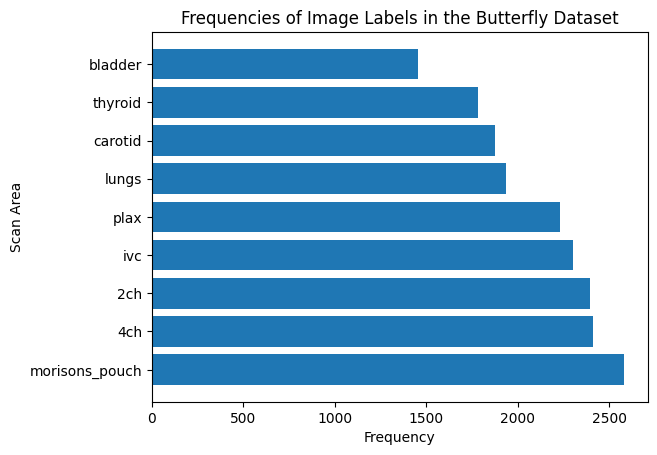

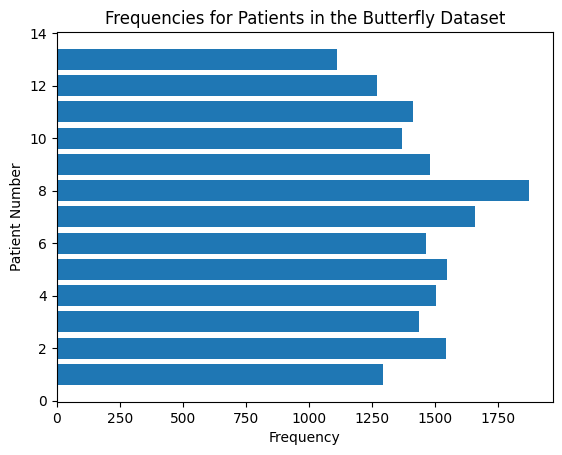

In [14]:
display(Markdown("#### General Information"))
display(df["Label"].describe())

label_counts = df['Label'].value_counts()
plt.barh(label_counts.index, label_counts.values)
plt.ylabel('Scan Area')
plt.xlabel('Frequency')
plt.title("Frequencies of Image Labels in the Butterfly Dataset")
plt.show()
del(label_counts)

patient_counts = df['Patient'].value_counts()
plt.barh(patient_counts.index, patient_counts.values)
plt.ylabel('Patient Number')
plt.xlabel('Frequency')
plt.title("Frequencies for Patients in the Butterfly Dataset")
plt.show()
del(patient_counts)

### Images

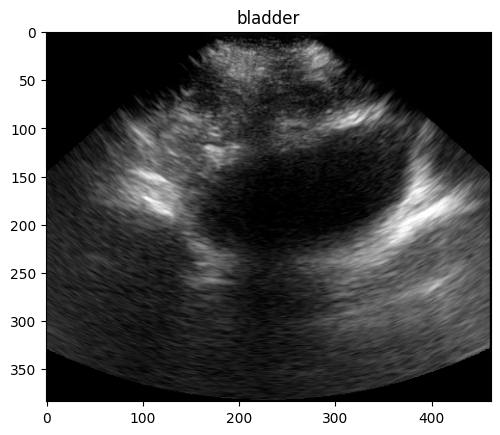

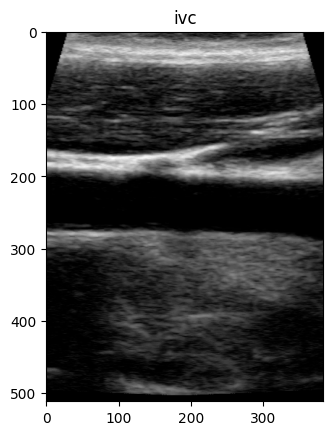

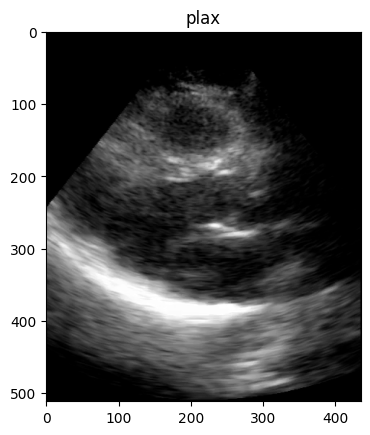

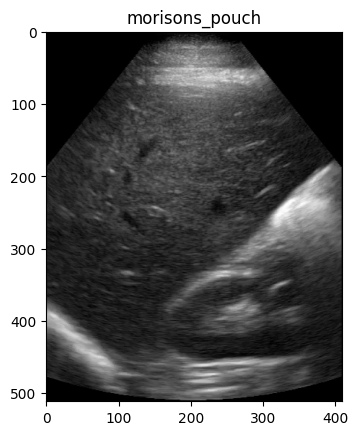

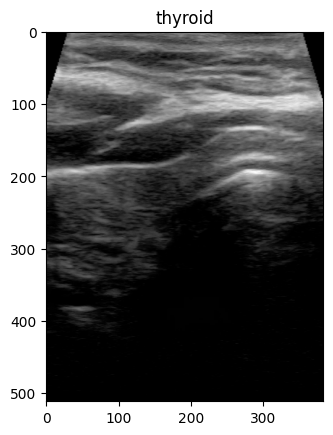

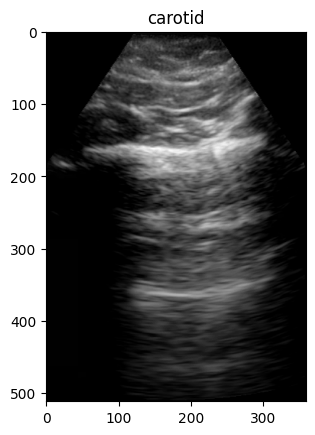

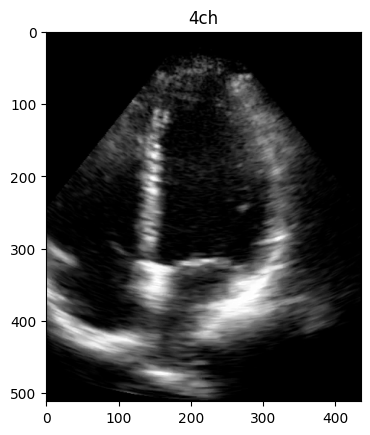

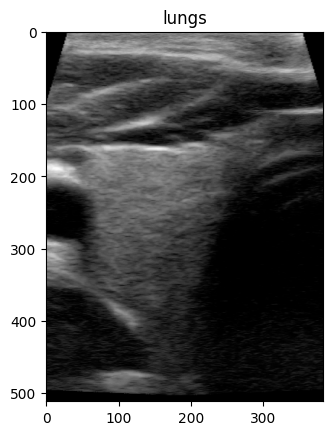

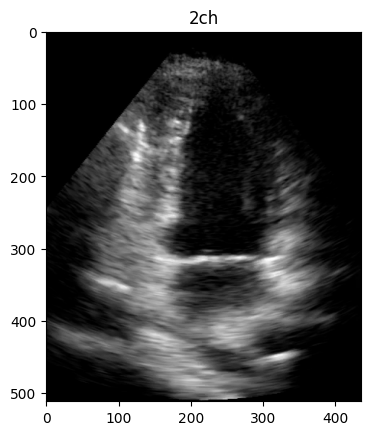

In [15]:
for label in labels:
    plt.imshow(df['Image'][(df['Label'] == label).idxmax()], cmap='gray')
    plt.title(label)
    plt.show()

Here are some observations based on the above data: 
1. Not all images are the same size
2. The scans look generally extremely distint. This should make it easy to identify with a low complexity model.

## Exploring Correlations

### Starting simple: means

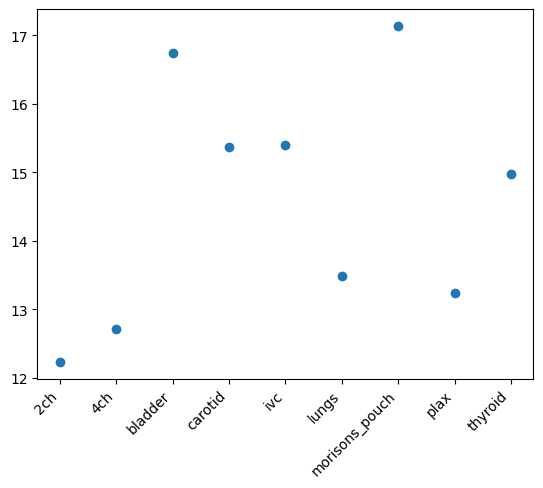

In [16]:
imageMean = np.vectorize(lambda image: np.mean(cv2.mean(image)[:3]))
df['Image_Mean'] = imageMean(df['Image'])
label_sorted_means = df.drop(['Image'], axis=1).groupby(['Label']).mean()
plt.scatter(label_sorted_means.index, label_sorted_means["Image_Mean"], label='Images')
plt.xticks(rotation=45, ha='right')
plt.show()
del(label_sorted_means)
del(imageMean)

This is a good start but it does not provide us with a ton of detail. Let's make some box plots instead

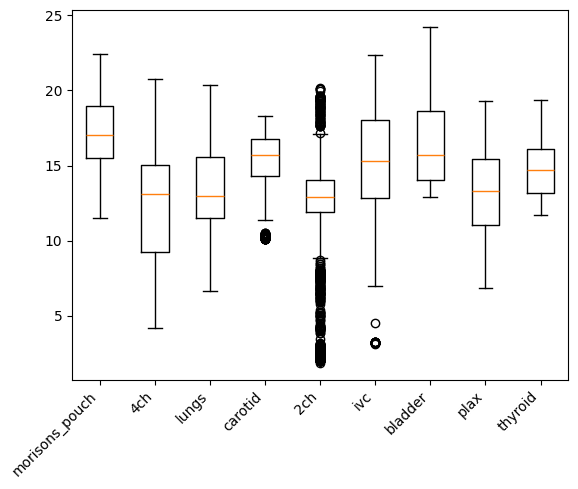

In [17]:
label_sorted_means = []
for label in df['Label'].unique():
    label_sorted_means.append(list(df[df["Label"] == label]["Image_Mean"]))
plt.boxplot(label_sorted_means, labels=list(df['Label'].unique()))
plt.xticks(rotation=45, ha='right')
plt.show()
del(label_sorted_means)

Observations: Mean is not a good way to interpret the datas.As we can see there is a very large amount of variance in this metric so we would not be able to tell any of our photo apart with any kind of confidence

### Growing Complexity: Nieve Bayes

In [18]:
image_size = (256,256)
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
df["Image Processed"] = [np.ndarray.flatten(cv2.resize(image, image_size)) for image in df['Image']]

In [19]:
model.fit(list(df['Image Processed']), list(df['Label']));

In [29]:
from sklearn.metrics import accuracy_score
df_test["Image Processed"] = [np.ndarray.flatten(cv2.resize(image, image_size)) for image in df_test['Image']]
predictions = model.predict(list(df_test['Image Processed']))
accuracy_score(predictions, df_test["Label"])